- Для каждого пользователя вычислить его любимую зону (любимой называем ту зону, в которой он больше всего простоял за интервал времни к примеру январь - февраль 2021 года и кол-во времени должно превышать 5 часов за 2 месяца
- Далее так же для каждой любимой пользователь-любимая зона надо понять регулярно или нет он там останавливался. Регулярно будем считать ту зону в которой кол-во уникальных дней за январь-февраль более 15.
- И дальше по произвольному дню нужно: для каждого часа-зоны- сумма времени регуляршиков, сумма всех времен, доля регуляршиков.

Описание структуры таблицы:
* ID - идентификатор сессии
* ACCOUNTID - идентификатор пользователя
* START_TIME - время старта сессии в unixtime
* END_TIME - время окончания сессии в unixtime
* ZONENUMBER - идентификатор парковочной зоны


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [2]:
data = pd.read_csv('data1.csv', delimiter=';')
display(data.head())
data.info()

,ID,ACCOUNTID,START_TIME,END_TIME,ZONENUMBER
0,374963901,6709301.0,1609448416165,1609449496165,c7ad
1,374964453,6170192.0,1609449343267,1609449463267,2745
2,374964422,6170567.0,1609449297411,1609449417411,8ee8
3,374964538,6709301.0,1609449459444,1609449579444,a54b
4,374964600,6170207.0,1609449549135,1609449669135,7468


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67237968 entries, 0 to 67237967
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ID          int64  
 1   ACCOUNTID   float64
 2   START_TIME  int64  
 3   END_TIME    int64  
 4   ZONENUMBER  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 2.5+ GB


In [3]:
# посмотрим сколько пользователей
len(data['ACCOUNTID'].unique())

2720184

In [4]:
# посмотрим сколько парковочных зон
len(data['ZONENUMBER'].unique())

276

In [5]:
# проверим сколько пропусков
print('Пропусков в ACCOUNTID-', len(data[data['ACCOUNTID'].isna()]))
print('Доля пропусков в ACCOUNTID-',len(data[data['ACCOUNTID'].isna()]) / len(data['ACCOUNTID']) )

Пропусков в ACCOUNTID- 456842
Доля пропусков в ACCOUNTID- 0.006794405208676146


In [6]:
# удалим пропуски
data = data.dropna()

In [7]:
# 'ACCOUNTID' переведем в целые цисла
data['ACCOUNTID'] = data['ACCOUNTID'].astype(int)

In [8]:
data['duration'] = ((data['END_TIME'] - data['START_TIME']) / 60000).astype(int)
data.head()

,ID,ACCOUNTID,START_TIME,END_TIME,ZONENUMBER,duration
0,374963901,6709301,1609448416165,1609449496165,c7ad,18
1,374964453,6170192,1609449343267,1609449463267,2745,2
2,374964422,6170567,1609449297411,1609449417411,8ee8,2
3,374964538,6709301,1609449459444,1609449579444,a54b,2
4,374964600,6170207,1609449549135,1609449669135,7468,2


In [9]:
# START_TIME и END_TIME приведем к виду даты и времени

data['START_TIME'] = pd.to_datetime(data['START_TIME'], unit="ms")
data['END_TIME'] = pd.to_datetime(data['END_TIME'], unit="ms")
data.head()

,ID,ACCOUNTID,START_TIME,END_TIME,ZONENUMBER,duration
0,374963901,6709301,2020-12-31 21:00:16.165,2020-12-31 21:18:16.165,c7ad,18
1,374964453,6170192,2020-12-31 21:15:43.267,2020-12-31 21:17:43.267,2745,2
2,374964422,6170567,2020-12-31 21:14:57.411,2020-12-31 21:16:57.411,8ee8,2
3,374964538,6709301,2020-12-31 21:17:39.444,2020-12-31 21:19:39.444,a54b,2
4,374964600,6170207,2020-12-31 21:19:09.135,2020-12-31 21:21:09.135,7468,2


#### Определение популярных парковочных зон

In [10]:
# добавим столбцы дня месяца и года
data['DAY'] = pd.DatetimeIndex(data['START_TIME']).day
data['MONTH'] = pd.DatetimeIndex(data['START_TIME']).month
data['YEAR'] = pd.DatetimeIndex(data['START_TIME']).year
data.head()

,ID,ACCOUNTID,START_TIME,END_TIME,ZONENUMBER,duration,DAY,MONTH,YEAR
0,374963901,6709301,2020-12-31 21:00:16.165,2020-12-31 21:18:16.165,c7ad,18,31,12,2020
1,374964453,6170192,2020-12-31 21:15:43.267,2020-12-31 21:17:43.267,2745,2,31,12,2020
2,374964422,6170567,2020-12-31 21:14:57.411,2020-12-31 21:16:57.411,8ee8,2,31,12,2020
3,374964538,6709301,2020-12-31 21:17:39.444,2020-12-31 21:19:39.444,a54b,2,31,12,2020
4,374964600,6170207,2020-12-31 21:19:09.135,2020-12-31 21:21:09.135,7468,2,31,12,2020


In [11]:
data.describe()

,ID,ACCOUNTID,duration,DAY,MONTH,YEAR
count,6.678113e+07,6.678113e+07,6.678113e+07,6.678113e+07,6.678113e+07,6.678113e+07
mean,4.533627e+08,3.712718e+06,5.545649e+01,1.613758e+01,6.821098e+00,2.021000e+03
std,4.517769e+07,2.912371e+06,8.623976e+01,8.715439e+00,3.338944e+00,3.258322e-03
min,3.749639e+08,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.020000e+03
25%,4.142323e+08,9.297060e+05,1.100000e+01,9.000000e+00,4.000000e+00,2.021000e+03
50%,4.534587e+08,2.940537e+06,3.000000e+01,1.600000e+01,7.000000e+00,2.021000e+03
75%,4.928008e+08,6.328111e+06,6.000000e+01,2.400000e+01,1.000000e+01,2.021000e+03
max,5.310696e+08,8.807579e+06,3.193800e+04,3.100000e+01,1.200000e+01,2.021000e+03


<AxesSubplot:>

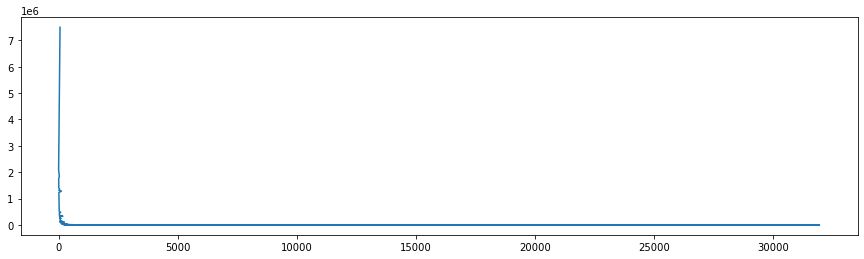

In [12]:
data['duration'].value_counts().plot(figsize=(15,4))

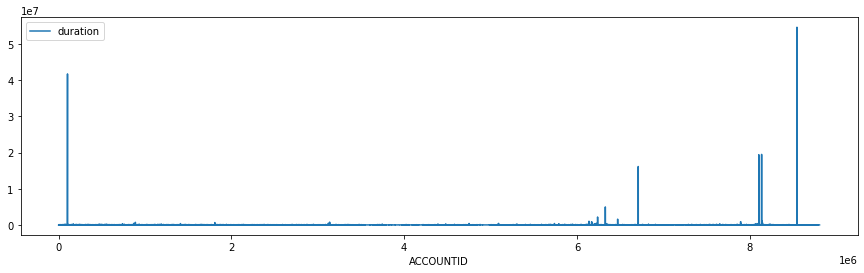

In [13]:
# проверим как много пользователей с постоянными местами парковки
user_stat = data.pivot_table(index='ACCOUNTID', values='duration', aggfunc='sum').plot(figsize=(15,4))


**Как видно таких не много**
сгруппируем пользователей и парковки и просуммируем общее время. Так мы отфильтруем пользователей с временем парковки меньше 5 часов.

In [14]:
# выбор периода с января по февраль 2021 года
data_jan_feb_21 = data[(data['START_TIME'] >= '2021-01-01') & (data['START_TIME'] < '2021-03-01')]
data_jan_feb_21

,ID,ACCOUNTID,START_TIME,END_TIME,ZONENUMBER,duration,DAY,MONTH,YEAR
541,374967021,6170251,2021-01-01 00:02:16.928,2021-01-01 00:04:16.928,bb8a,2,1,1,2021
544,374967045,3122050,2021-01-01 00:04:30.425,2021-01-01 01:04:30.425,01c7,60,1,1,2021
550,374967037,6709301,2021-01-01 00:03:54.054,2021-01-01 00:10:54.054,c4dc,7,1,1,2021
554,374967064,6170245,2021-01-01 00:06:43.210,2021-01-01 01:06:43.210,480f,60,1,1,2021
568,374967078,6202087,2021-01-01 00:08:26.179,2021-01-01 01:08:26.179,9788,60,1,1,2021
...,...,...,...,...,...,...,...,...,...
9144382,393697652,6709301,2021-02-28 12:15:29.442,2021-03-03 10:18:29.442,ccc6,4203,28,2,2021
9273005,393752520,3345982,2021-02-28 21:09:11.330,2021-03-03 13:59:11.330,24ad,3890,28,2,2021
9292124,393450901,4022361,2021-02-27 13:10:06.922,2021-03-03 14:00:06.922,f83b,5810,27,2,2021
9413485,393716143,8170106,2021-02-28 14:29:07.378,2021-03-03 18:34:07.378,f9bf,4565,28,2,2021


In [15]:
# группировка данных по пользователю и по зоне с суммированием общего времени проведенного в этой зоне
user_group = data_jan_feb_21.groupby(['ACCOUNTID', 'ZONENUMBER']).agg({'duration': ['sum']}).reset_index()
user_group

,ACCOUNTID,ZONENUMBER,duration
,,,sum
0,1,29b1,1
1,8,19b0,96
2,8,fa4c,139
3,12,19b0,12
4,12,4041,11
...,...,...,...
3566643,8173963,2634,104
3566644,8173964,2634,34
3566645,8173972,0a80,6


In [16]:
# переименуем столбцы
user_group.columns = ['id', 'zone', 'min']
user_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3566648 entries, 0 to 3566647
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   zone    object
 2   min     int32 
dtypes: int32(1), int64(1), object(1)
memory usage: 68.0+ MB


In [17]:
# выбор пользователей с временем парковки >= 5 часов
users_select = user_group[user_group['min']>=300]
users_select

,id,zone,min
34,65,ccac,416
147,221,8ee8,616
164,224,0432,300
222,242,2634,300
226,242,a444,480
...,...,...,...
3566607,8173612,a54b,300
3566614,8173663,0231,574
3566617,8173695,7e3a,2455
3566630,8173864,e76a,619


In [18]:
# получим список ID пользователей с временем парковки >= 5 часов
users_list = users_select['id'].unique()
users_list

array([     65,     221,     224, ..., 8173695, 8173864, 8173990],
      dtype=int64)

In [19]:
# получим список зон с временем парковки >= 5 часов
zone_list = users_select['zone'].unique()
len(zone_list)

173

### Теперь необходимо проверить пользователей являются ли они регулярными

In [20]:
like_user_zone = data_jan_feb_21[(data_jan_feb_21['ACCOUNTID'].isin(users_list)\
                                 & data_jan_feb_21['ZONENUMBER'].isin(zone_list))]
like_user_zone

,ID,ACCOUNTID,START_TIME,END_TIME,ZONENUMBER,duration,DAY,MONTH,YEAR
541,374967021,6170251,2021-01-01 00:02:16.928,2021-01-01 00:04:16.928,bb8a,2,1,1,2021
544,374967045,3122050,2021-01-01 00:04:30.425,2021-01-01 01:04:30.425,01c7,60,1,1,2021
550,374967037,6709301,2021-01-01 00:03:54.054,2021-01-01 00:10:54.054,c4dc,7,1,1,2021
554,374967064,6170245,2021-01-01 00:06:43.210,2021-01-01 01:06:43.210,480f,60,1,1,2021
568,374967078,6202087,2021-01-01 00:08:26.179,2021-01-01 01:08:26.179,9788,60,1,1,2021
...,...,...,...,...,...,...,...,...,...
9144382,393697652,6709301,2021-02-28 12:15:29.442,2021-03-03 10:18:29.442,ccc6,4203,28,2,2021
9273005,393752520,3345982,2021-02-28 21:09:11.330,2021-03-03 13:59:11.330,24ad,3890,28,2,2021
9292124,393450901,4022361,2021-02-27 13:10:06.922,2021-03-03 14:00:06.922,f83b,5810,27,2,2021
9413485,393716143,8170106,2021-02-28 14:29:07.378,2021-03-03 18:34:07.378,f9bf,4565,28,2,2021


In [21]:
like_user_zone_group = pd.DataFrame(like_user_zone.groupby(['ACCOUNTID', 'ZONENUMBER'])['DAY'].count().reset_index())
like_user_zone_group = like_user_zone_group[like_user_zone_group['DAY'] > 15]
like_user_zone_group

,ACCOUNTID,ZONENUMBER,DAY
24,250,a77f,18
79,333,df8e,19
101,354,df8e,16
123,412,19b0,25
215,564,fa4c,26
...,...,...,...
981607,8149505,6b91,22
981718,8151192,8ee8,19
981988,8155552,0432,22
982164,8158969,cab7,21


Мы определили пользователей которые пользуются любимыми парковочными зонами регулярно

<AxesSubplot:xlabel='ZONENUMBER', ylabel='DAY'>

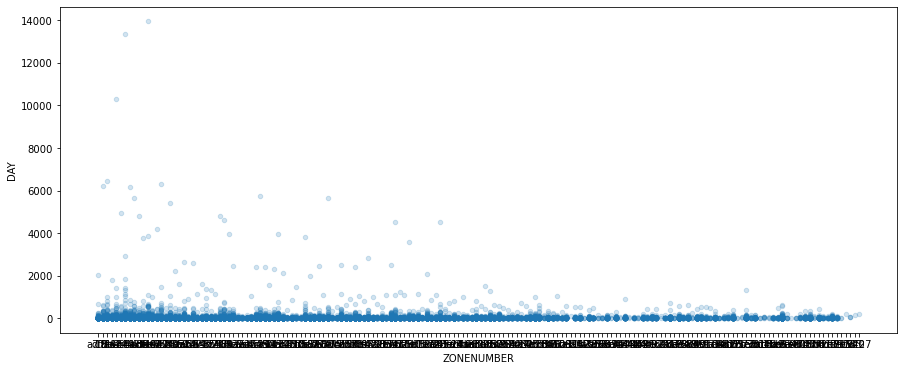

In [22]:
like_user_zone_group.plot(x='ZONENUMBER', y='DAY', kind='scatter', alpha=0.2, figsize=(15,6))

<AxesSubplot:xlabel='ZONENUMBER'>

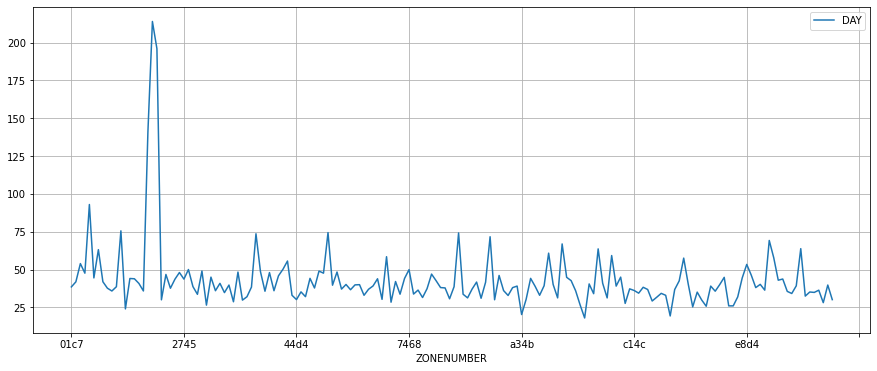

In [23]:
like_user_zone_group.pivot_table(index='ZONENUMBER', values='DAY').plot(grid=True, figsize=(15,6))

#### для каждого часа-зоны- сумма времени регуляршиков, сумма всех времен, доля регуляршиков

In [24]:
# получим список регулярных пользователей
regular_users = like_user_zone_group['ACCOUNTID'].unique()
regular_users

array([    250,     333,     354, ..., 8155552, 8158969, 8160561],
      dtype=int64)

In [25]:
# выбор данных за 1 день
selected_day = datetime(year=2021, month=1, day=1) #'2021-01-01'
data_1_day = data[(data['START_TIME'] >= selected_day)\
                 & (data['START_TIME'] < selected_day + pd.DateOffset(days=1))]
data_1_day.head()

,ID,ACCOUNTID,START_TIME,END_TIME,ZONENUMBER,duration,DAY,MONTH,YEAR
541,374967021,6170251,2021-01-01 00:02:16.928,2021-01-01 00:04:16.928,bb8a,2,1,1,2021
544,374967045,3122050,2021-01-01 00:04:30.425,2021-01-01 01:04:30.425,01c7,60,1,1,2021
550,374967037,6709301,2021-01-01 00:03:54.054,2021-01-01 00:10:54.054,c4dc,7,1,1,2021
554,374967064,6170245,2021-01-01 00:06:43.210,2021-01-01 01:06:43.210,480f,60,1,1,2021
568,374967078,6202087,2021-01-01 00:08:26.179,2021-01-01 01:08:26.179,9788,60,1,1,2021


In [26]:
# добавляем значение часа
data_1_day['HOUR'] = pd.DatetimeIndex(data_1_day['START_TIME']).hour
data_1_day

C:\Users\edelv\AppData\Local\Temp/ipykernel_26748/3142562008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1_day['HOUR'] = pd.DatetimeIndex(data_1_day['START_TIME']).hour


,ID,ACCOUNTID,START_TIME,END_TIME,ZONENUMBER,duration,DAY,MONTH,YEAR,HOUR
541,374967021,6170251,2021-01-01 00:02:16.928,2021-01-01 00:04:16.928,bb8a,2,1,1,2021,0
544,374967045,3122050,2021-01-01 00:04:30.425,2021-01-01 01:04:30.425,01c7,60,1,1,2021,0
550,374967037,6709301,2021-01-01 00:03:54.054,2021-01-01 00:10:54.054,c4dc,7,1,1,2021,0
554,374967064,6170245,2021-01-01 00:06:43.210,2021-01-01 01:06:43.210,480f,60,1,1,2021,0
568,374967078,6202087,2021-01-01 00:08:26.179,2021-01-01 01:08:26.179,9788,60,1,1,2021,0
...,...,...,...,...,...,...,...,...,...,...
15101,374983413,6709301,2021-01-01 19:50:48.044,2021-01-02 11:42:48.044,5edf,952,1,1,2021,19
15268,374983503,6709301,2021-01-01 19:56:07.846,2021-01-02 17:39:07.846,356a,1303,1,1,2021,19
15410,374982485,6470844,2021-01-01 19:00:57.659,2021-01-02 18:00:57.659,d581,1380,1,1,2021,19
15933,374973293,102774,2021-01-01 10:57:08.003,2021-01-02 19:37:08.003,b8a7,1960,1,1,2021,10


In [27]:
data_1_day_group = data_1_day.groupby(['ZONENUMBER', 'HOUR', 'ACCOUNTID']).agg({'duration': ['sum']}).reset_index()
data_1_day_group.columns = ['ZONENUMBER', 'HOUR', 'ACCOUNTID', 'SUM']
data_1_day_group

,ZONENUMBER,HOUR,ACCOUNTID,SUM
0,01c7,0,3122050,60
1,01c7,7,6709301,52
2,0231,0,3122050,60
3,0231,0,6201978,60
4,0231,1,3122050,60
...,...,...,...,...
4485,fdd9,23,6170412,60
4486,fdd9,23,6170443,60
4487,fdd9,23,6170522,60
4488,fdd9,23,6202194,60


<AxesSubplot:xlabel='HOUR'>

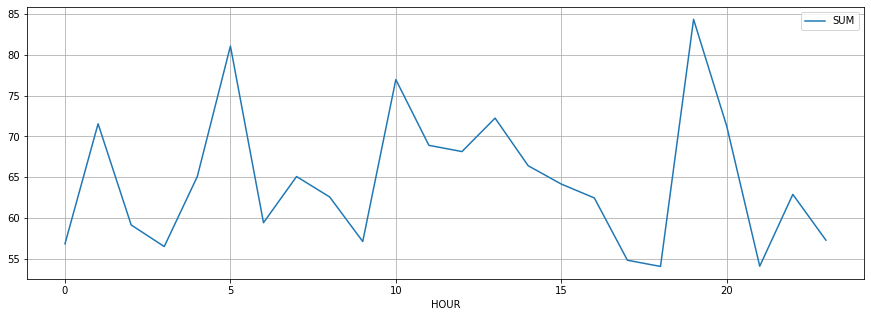

In [28]:
data_1_day_group.pivot_table(index='HOUR', values='SUM').plot(grid=True, figsize=(15,5))

In [29]:
zone_hour_total = data_1_day_group.groupby(['ZONENUMBER', 'HOUR']).sum()
zone_hour_total

ACCOUNTID  SUM
ZONENUMBER HOUR                
01c7       0       3122050   60
           7       6709301   52
0231       0       9324028  120
           1      13905148  180
           2       9324028  108
...                    ...  ...
fdd9       19     43244130  420
           20     43244129  420
           21     43244129  420
           22     43244129  420
           23     43244132  420

[1956 rows x 2 columns]

In [30]:
zone_hour_regular = data_1_day_group.query('ACCOUNTID in@regular_users')\
.pivot_table(index=['ZONENUMBER', 'HOUR'], values='SUM', aggfunc='sum')
zone_hour_regular

SUM
ZONENUMBER HOUR     
01c7       0      60
           7      52
0231       0     120
           1     180
           2     108
...              ...
fdd9       19    420
           20    420
           21    420
           22    420
           23    360

[1817 rows x 1 columns]

Добавим столбцы с суммами по часу в каждой зоне и найдем соотношение

In [31]:
zone_hour_total['regular_sum'] = zone_hour_regular['SUM']
zone_hour_total['percent'] = zone_hour_total['regular_sum'] / zone_hour_total['SUM'] * 100
zone_hour_total

ACCOUNTID  SUM  regular_sum     percent
ZONENUMBER HOUR                                         
01c7       0       3122050   60         60.0  100.000000
           7       6709301   52         52.0  100.000000
0231       0       9324028  120        120.0  100.000000
           1      13905148  180        180.0  100.000000
           2       9324028  108        108.0  100.000000
...                    ...  ...          ...         ...
fdd9       19     43244130  420        420.0  100.000000
           20     43244129  420        420.0  100.000000
           21     43244129  420        420.0  100.000000
           22     43244129  420        420.0  100.000000
           23     43244132  420        360.0   85.714286

[1956 rows x 4 columns]

<AxesSubplot:title={'center':'Соотношение времени регулярных посетителей'}, xlabel='ZONENUMBER,HOUR'>

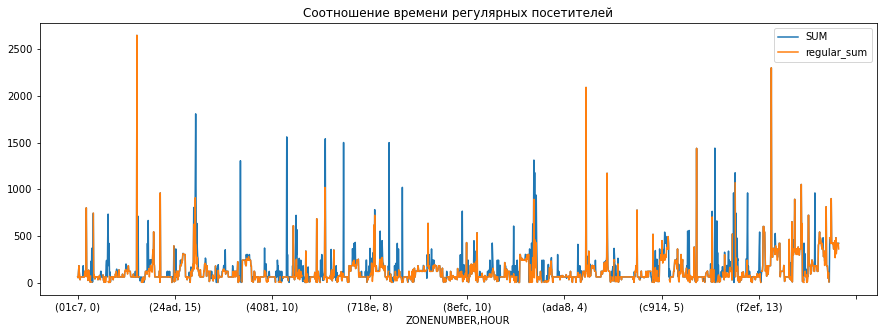

In [32]:
zone_hour_total.plot(y=['SUM', 'regular_sum'],
                     title='Соотношение времени регулярных посетителей',
                     figsize=(15,5))